In [1]:
import os
import numpy as np

# Downloading test & train dataset 

In [2]:
def load_dataset():
    def download(filename, source= 'http://yann.lecun.com/exdb/mnist/'):
        print('downloading', filename)
        import urllib
        urllib.request.urlretrieve(source+filename, filename)
        
    import gzip
    
    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename,'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
            data = data.reshape(-1,1,28,28)
            #print(data[0])
            return data/np.float32(256)
    
    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename,'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data
    
    x_trains = load_mnist_images('train-images-idx3-ubyte.gz')
    y_trains = load_mnist_labels('train-labels-idx1-ubyte.gz')
    x_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')
    
    return x_trains, y_trains, x_test, y_test

In [3]:
x_train, y_train, x_test, y_test = load_dataset()

In [3]:
import matplotlib
import matplotlib.pyplot as plt

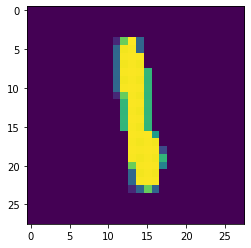

In [5]:
plt.show(plt.imshow(x_train[200][0]))

In [6]:
import lasagne
import theano
import theano.tensor as T

def build_NN(input_var = None):
    l_in = lasagne.layers.InputLayer( shape=(None, 1,28,28), input_var = input_var)
    l_in_drop = lasagne.layers.DropoutLayer(l_in , p=0.2)
    # 1st hidden layer
    l_hid1 = lasagne.layers.DenseLayer(l_in_drop, num_units=800, 
                                        nonlinearity = lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1 , p=0.5)
    
    # 2nd hidden layer
    l_hid2 = lasagne.layers.DenseLayer(l_hid1_drop, num_units=800, 
                                        nonlinearity = lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    l_hid2_drop = lasagne.layers.DropoutLayer(l_hid2 , p=0.5)
    
    # output layer
    l_out = lasagne.layers.DenseLayer(l_hid2_drop, num_units=10, 
                                        nonlinearity = lasagne.nonlinearities.softmax)
    #print("called")
    return l_out


input_var = T.tensor4('input')
target_var = T.ivector('target')
network = build_NN(input_var)

prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)

loss = loss.mean()
params = lasagne.layers.get_all_params(network, trainable = True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate =0.01, momentum =0.9)

train_fn = theano.function([input_var, target_var], loss, updates = updates)


In [7]:
num_training_steps = 1

for step in range(num_training_steps):
    print("started"+str(step))
    train_err = train_fn(x_train,y_train)
    print('current step is '+str(step))
    

started0
current step is 0


In [8]:
test_prediction = lasagne.layers.get_output(network)
val_fn  = theano.function([input_var], test_prediction)

ans = val_fn([x_test[9]])
digit = np.argmax(ans)

[[0.05605423 0.10248132 0.0971081  0.0728626  0.1239671  0.05083763
  0.06196882 0.06688117 0.08436835 0.28347068]]   9


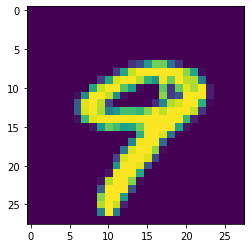

In [9]:
print(ans," ",digit)
plt.show(plt.imshow(x_test[9][0]))

In [10]:
y_test[9]

9

In [11]:
test_prediction = lasagne.layers.get_output(network , deterministic = True)
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis =1), target_var), dtype = theano.config.floatX)

acc_fn = theano.function([input_var, target_var], test_acc)
acc_fn(x_test , y_test)

array(0.1066)

In [12]:
import pyttsx3
import inflect

In [13]:
def pred_number(number):
    ans = val_fn([x_test[number]])
    digit = np.argmax(ans)
    return digit

numbers=[]
numbers.append(pred_number(9))
numbers.append(pred_number(10))

#plt.show(plt.imshow(x_test[9][0]))

In [14]:
number = 0
for num in numbers:
    number = number *10
    number = number + num
print(number)

78


In [15]:
p = inflect.engine()
words = p.number_to_words(number)

In [16]:
engine = pyttsx3.init()
engine.say(words)
engine.runAndWait()

In [17]:
len(x_test[9][0])

28

In [4]:
from PIL import Image, ImageFilter



def imageprepare(argv):
    """
    This function returns the pixel values.
    The imput is a png file location.
    """
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255))  # creates white canvas of 28x28 pixels

    if width > height:  # check which dimension is bigger
        # Width is bigger. Width becomes 20 pixels.
        nheight = int(round((20.0 / width * height), 0))  # resize height according to ratio width
        if (nheight == 0):  # rare case but minimum is 1 pixel
            nheight = 1
            # resize and sharpen
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))  # calculate horizontal position
        newImage.paste(img, (4, wtop))  # paste resized image on white canvas
    else:
        # Height is bigger. Heigth becomes 20 pixels.
        nwidth = int(round((20.0 / height * width), 0))  # resize width according to ratio height
        if (nwidth == 0):  # rare case but minimum is 1 pixel
            nwidth = 1
            # resize and sharpen
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))  # caculate vertical pozition
        newImage.paste(img, (wleft, 4))  # paste resized image on white canvas

    # newImage.save("sample.png

    tv = list(newImage.getdata())  # get pixel values

    # normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [(255 - x) * 1.0 / 255.0 for x in tv]
    #print(tva)
    return tva

x=[imageprepare('./image.png')]#file path here
#print(len(x))# mnist IMAGES are 28x28=784 pixels
#print(x[0])
#Now we convert 784 sized 1d array to 24x24 sized 2d array so that we can visualize it
newArr=[[0 for d in range(28)] for y in range(28)]
k = 0
for i in range(28):
    for j in range(28):
        newArr[i][j]=x[0][k]
        k=k+1


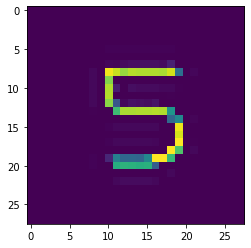

In [5]:
plt.show(plt.imshow(newArr))

In [20]:
result = val_fn([[newArr]])
digits = np.argmax(ans)

In [21]:
print(result," ",digits)

[[0.13426529 0.1066145  0.08390186 0.06324212 0.09642446 0.05244022
  0.05297332 0.18987836 0.13629407 0.08396579]]   9


In [2]:
from tkinter import *
from PIL import Image, ImageTk
from tkinter import filedialog
import matplotlib.image as mpimg
%matplotlib qt

In [3]:
def predict(path):
    x=[imageprepare(path)]
    
    newArr=[[0 for d in range(28)] for y in range(28)]
    k = 0
    for i in range(28):
        for j in range(28):
            newArr[i][j]=x[0][k]
            k=k+1
    
    plt.show(plt.imshow(newArr))        
    result = val_fn([[newArr]])
    #print(ans)
    digits = np.argmax(ans)
    return digits

    

In [9]:
root = Tk()
root.title('Digit Recognizition')
root.geometry("400x400")
mylabel = Label(root)


'''root.filename = filedialog.askopenfilename(initialdir="G:\ML\digit recog", title="Select a Image", 
                                           filetypes=(("png files","*.png"),("All Files","*.*")) )
if root.filename != '':
    #print("called "+root.filename)
    myimage = ImageTk.PhotoImage(Image.open(root.filename))
    my_image_label = Label(root, image = myimage).pack()'''

def img():
    root.filename = filedialog.askopenfilename(initialdir="G:\ML\digit recog", title="Select a Image", 
                                           filetypes=(("png files","*.png"),("All Files","*.*")) )
    if root.filename != '':
        #print("called fn "+root.filename)
        img = mpimg.imread(root.filename)
        imgplot = plt.imshow(img)
        plt.show()
        #myimage = ImageTk.PhotoImage(Image.open(root.filename))
        #my_image_label = Label(root, image = myimage).pack()


def printpred():
    #print(root.filename)
    global mylabel
    if mylabel:
        mylabel.destroy()
        
    
    val = predict(root.filename)
    ans = " predicted val is "+str(val)
    mylabel = Label(root , text= ans).pack()
    #print(ans)

pathbtn = Button(root, text= "Selec Image", command =img )
pathbtn.pack(pady=10)
    
#mybutton = Button(root, text= "Predict the Digit", command =printpred )
#mybutton.pack(pady=10)


root.mainloop()